In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
os.environ['TFHUB_DOWNLOAD_PROGRESS']='True'

In [2]:
import requests
path = 'https://news.mit.edu/sites/default/files/images/201902/MIMIC-CXR-Chest-X-Ray-00.jpeg'
r = requests.get(path, allow_redirects=True)
open('MIMIC-CXR-Chest-X-Ray-00.jpeg', 'wb').write(r.content)

IMAGE_PATH = 'MIMIC-CXR-Chest-X-Ray-00.jpeg'
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"


In [3]:
iah = Image.open("MIMIC-CXR-Chest-X-Ray-00.jpeg")
t_img = tf.convert_to_tensor(iah, dtype=tf.float32)
print(t_img.get_shape())
iah.size

(352, 498, 3)


(498, 352)

In [4]:
# function to preprocess image so that it can be handled by model
def preprocess_image(image_path):
   image = tf.image.decode_image(tf.io.read_file(image_path))
   if image.shape[-1] == 4:
     image = image[...,:-1]
   size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
   image = tf.image.crop_to_bounding_box(image, 0, 0, size[0], size[1])
   image = tf.cast(image,tf.float32)
   return tf.expand_dims(image,0)

def save_image(image,filename):
  if not isinstance(image, Image.Image):
      image = tf.clip_by_value(image, 0, 255)
      image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save('%s.jpg' % filename)
  print('Saved as %s.jpg' % filename)

In [5]:
preprocess_image(IMAGE_PATH)

<tf.Tensor: shape=(1, 352, 496, 3), dtype=float32, numpy=
array([[[[  9.,   9.,   9.],
         [ 14.,  14.,  14.],
         [ 13.,  13.,  13.],
         ...,
         [ 21.,  21.,  21.],
         [ 21.,  21.,  21.],
         [ 21.,  21.,  21.]],

        [[  6.,   6.,   6.],
         [ 10.,  10.,  10.],
         [ 10.,  10.,  10.],
         ...,
         [ 21.,  21.,  21.],
         [ 21.,  21.,  21.],
         [ 21.,  21.,  21.]],

        [[  7.,   7.,   7.],
         [ 11.,  11.,  11.],
         [ 10.,  10.,  10.],
         ...,
         [ 22.,  22.,  22.],
         [ 22.,  22.,  22.],
         [ 22.,  22.,  22.]],

        ...,

        [[146., 146., 146.],
         [146., 146., 146.],
         [145., 145., 145.],
         ...,
         [127., 127., 127.],
         [123., 123., 123.],
         [123., 123., 123.]],

        [[145., 145., 145.],
         [146., 146., 146.],
         [145., 145., 145.],
         ...,
         [125., 125., 125.],
         [120., 120., 120.],
         

In [6]:
#%matplotlib inline
def plot_image(image,title=''):

  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis('off')
  plt.title(title)


In [7]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



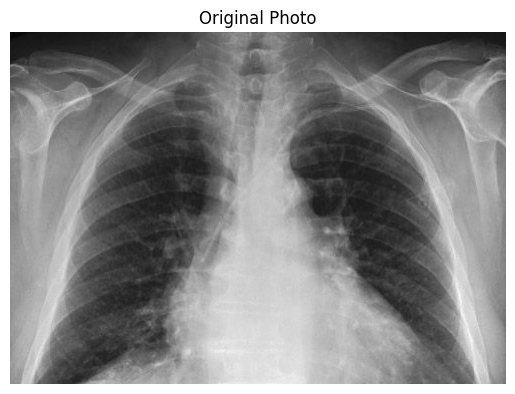

In [8]:
load_image = preprocess_image(IMAGE_PATH)

# plot original image
plot_image(tf.squeeze(load_image),title='Original Photo')

In [9]:
# Start Performing resolution
start = time.time()
super_image = model(load_image)
super_image = tf.squeeze(super_image)
print('Time taken to complete process: %f'%(time.time() - start))

Time taken to complete process: 43.817148


In [10]:
print(super_image.get_shape())

(1408, 1984, 3)


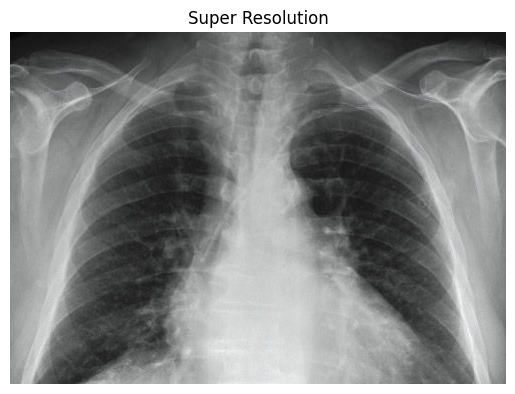

In [11]:
#plot the output image
plot_image(tf.squeeze(super_image),'Super Resolution')

In [12]:
IMAGE_PATH = "MIMIC-CXR-Chest-X-Ray-00.jpeg"

In [13]:
def downscale_image(image):

  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(tf.cast(tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(Image.fromarray(image.numpy()).resize([image_size[0] // 4, image_size[1] // 4],Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [14]:
#hr_image = preprocess_image('IMAGE_PATH')
hr_image = preprocess_image('MIMIC-CXR-Chest-X-Ray-00.jpeg')

In [15]:
lr_image = downscale_image(tf.squeeze(hr_image))

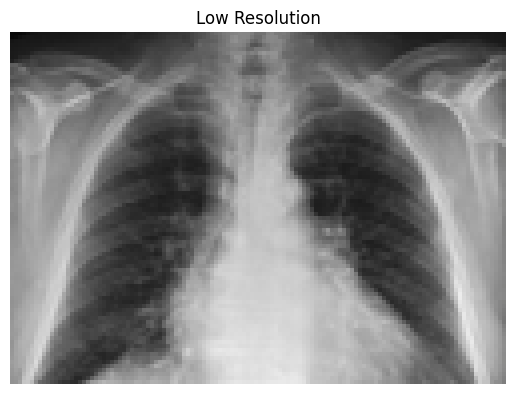

In [16]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")
lr_image1 = tf.image.resize(lr_image, [352,496], antialias=False)
# print(tf.shape(tf.clip_by_value(hr_image, 0, 255)))
# # Calculating PSNR wrt Original Image
# psnr = tf.image.psnr(
#     tf.clip_by_value(lr_image1, 0, 255),
#     tf.clip_by_value(hr_image, 0, 255), max_val=255)
# print("PSNR Achieved: %f" % psnr)

In [17]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 4.308936


PSNR Achieved: 35.518875


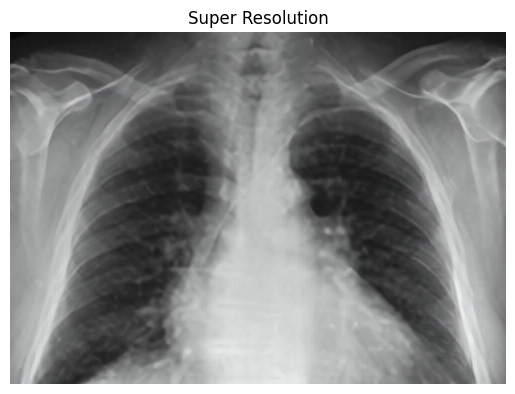

In [18]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 35.518875


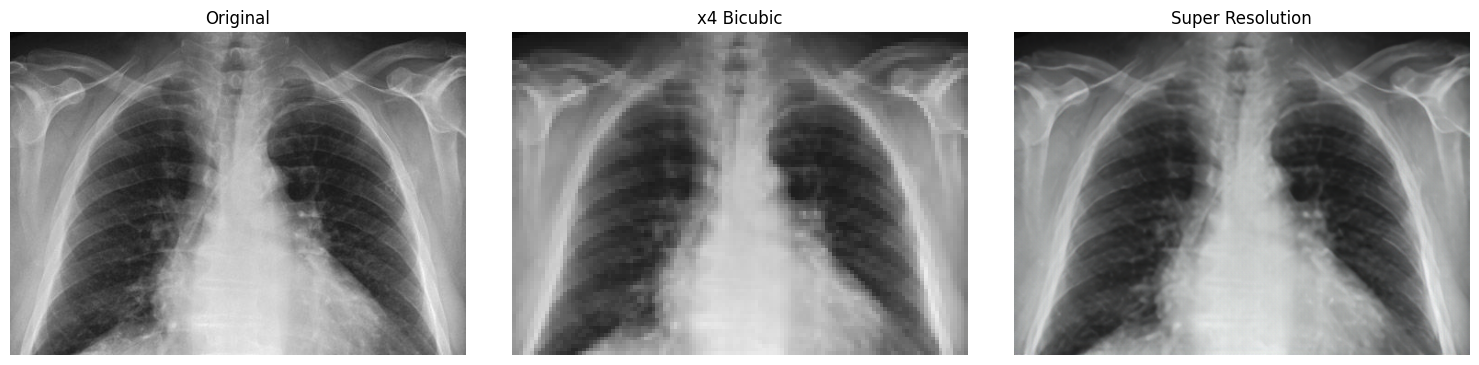

In [19]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)